In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
from scipy import stats
import jenkspy
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('Superstore.csv')

In [5]:
df.head(5)

,Order ID,Order Date,Customer ID,Region,Product ID,Quantity,Sales
0,MX-2014-143658,2/10/2014,SC-20575,North,OFF-LA-10002782,3,13.08
1,MX-2012-155047,10/15/2012,KW-16570,South,FUR-FU-10004015,8,252.16
2,MX-2012-155047,10/15/2012,KW-16570,South,FUR-BO-10002352,2,193.28
3,MX-2012-155047,10/15/2012,KW-16570,South,OFF-BI-10004428,4,35.44
4,MX-2012-155047,10/15/2012,KW-16570,South,OFF-AR-10004594,2,71.60


In [6]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [7]:
anchorDate = dt.datetime(2015,1,1)

In [8]:
rfm = df.groupby('Customer ID').agg({'Order Date': lambda x: (anchorDate - x.max()).days,
                                    'Order ID': lambda x: len(x),
                                    'Sales': lambda x: x.sum()})

In [9]:
rfm.head(5)

,Order Date,Order ID,Sales
Customer ID,,,
AA-10315,9,42,15578.04
AA-10375,7,42,7272.89
AA-10480,118,38,18467.63
AA-10645,27,73,16691.92
AA-315,3,8,2499.63


In [10]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1590 entries, AA-10315 to ZD-21925
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Order Date  1590 non-null   int64  
 1   Order ID    1590 non-null   int64  
 2   Sales       1590 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 49.7+ KB


In [11]:
rfm.columns = ['Recency', 'Frequency', 'Monetary']

In [12]:
rfm.head(5)

,Recency,Frequency,Monetary
Customer ID,,,
AA-10315,9,42,15578.04
AA-10375,7,42,7272.89
AA-10480,118,38,18467.63
AA-10645,27,73,16691.92
AA-315,3,8,2499.63


In [14]:
rfm['r_percentile'] = rfm['Recency'].rank(pct=True,ascending=False)
rfm['r_score'] = pd.qcut(rfm['r_percentile'], 4, labels=range(4,0,-1))

rfm['f_percentile'] = rfm['Frequency'].rank(pct=True,ascending=True)
rfm['f_score'] = pd.qcut(rfm['f_percentile'], 4, labels=range(4,0,-1))

rfm['m_percentile'] = rfm['Monetary'].rank(pct=True,ascending=True)
rfm['m_score'] = pd.qcut(rfm['m_percentile'], 4, labels=range(4,0,-1))

In [15]:
rfm.head(5)

,Recency,Frequency,Monetary,r_percentile,r_score,f_percentile,f_score,m_percentile,m_score
Customer ID,,,,,,,,,
AA-10315,9,42,15578.04,0.826101,1,0.610063,2,0.760377,1
AA-10375,7,42,7272.89,0.868239,1,0.610063,2,0.496855,3
AA-10480,118,38,18467.63,0.213522,4,0.563836,2,0.850943,1
AA-10645,27,73,16691.92,0.609434,2,0.979560,1,0.793082,1
AA-315,3,8,2499.63,0.937421,1,0.123899,4,0.299371,3


In [16]:
rfm['rfm_score'] = rfm['r_score'].astype(str) + rfm['f_score'].astype(str) + rfm['m_score'].astype(str)

In [17]:
rfm.head(5)

,Recency,Frequency,Monetary,r_percentile,r_score,f_percentile,f_score,m_percentile,m_score,rfm_score
Customer ID,,,,,,,,,,
AA-10315,9,42,15578.04,0.826101,1,0.610063,2,0.760377,1,121
AA-10375,7,42,7272.89,0.868239,1,0.610063,2,0.496855,3,123
AA-10480,118,38,18467.63,0.213522,4,0.563836,2,0.850943,1,421
AA-10645,27,73,16691.92,0.609434,2,0.979560,1,0.793082,1,211
AA-315,3,8,2499.63,0.937421,1,0.123899,4,0.299371,3,143


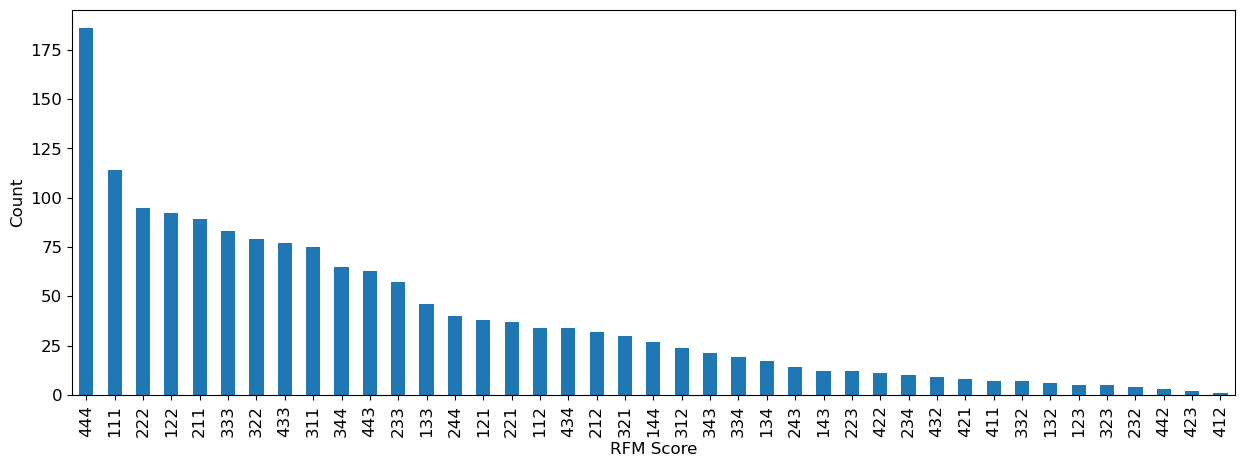

In [18]:
ax = rfm['rfm_score'].value_counts().plot(kind='bar', figsize=(15, 5), fontsize=12)
ax.set_xlabel("RFM Score", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

In [20]:
r_quarters = rfm['Recency'].quantile(q=[0.0, 0.25,0.5,0.75,1]).to_list()
f_quarters = rfm['Frequency'].quantile(q=[0.0, 0.25,0.5,0.75,1]).to_list()
m_quarters = rfm['Monetary'].quantile(q=[0.0, 0.25,0.5,0.75,1]).to_list()
quartile_spread = pd.DataFrame(list(zip(r_quarters, f_quarters, m_quarters)), columns=['Q_Recency', 'Q_frequency', 'Q_Monetary'], index = ['min', 'first_part','second_part','third_part', 'max'])
quartile_spread

,Q_Recency,Q_frequency,Q_Monetary
min,1.0,1.0,23.910
first_part,15.0,12.0,2014.170
second_part,41.0,28.0,7451.560
third_part,104.0,52.0,15316.845
max,1119.0,97.0,39718.990


In [26]:
r_breaks = jenkspy.jenks_breaks(rfm['Recency'], n_classes=4)
f_breaks = jenkspy.jenks_breaks(rfm['Frequency'], n_classes=4)
m_breaks = jenkspy.jenks_breaks(rfm['Monetary'], n_classes=4)
jenks_spread = pd.DataFrame(list(zip(r_breaks, f_breaks, m_breaks)), 
                      columns=['J_Recency','J_Frequency', 'J_Monetary'],
                     index = ['min', 'first_part','second_part','third_part', 'max'])
jenks_spread

,J_Recency,J_Frequency,J_Monetary
min,1,1,23.91
first_part,84,24,6587.25
second_part,252,44,13859.07
third_part,516,60,21075.61
max,1119,97,39718.99


In [28]:
df = pd.concat([quartile_spread, jenks_spread], axis=1)
cols = ['Q_Recency', 'Q_frequency', 'Q_Monetary', 'J_Recency', 'J_Frequency', 'J_Monetary']
df[cols]

,Q_Recency,Q_frequency,Q_Monetary,J_Recency,J_Frequency,J_Monetary
min,1.0,1.0,23.910,1,1,23.91
first_part,15.0,12.0,2014.170,84,24,6587.25
second_part,41.0,28.0,7451.560,252,44,13859.07
third_part,104.0,52.0,15316.845,516,60,21075.61
max,1119.0,97.0,39718.990,1119,97,39718.99


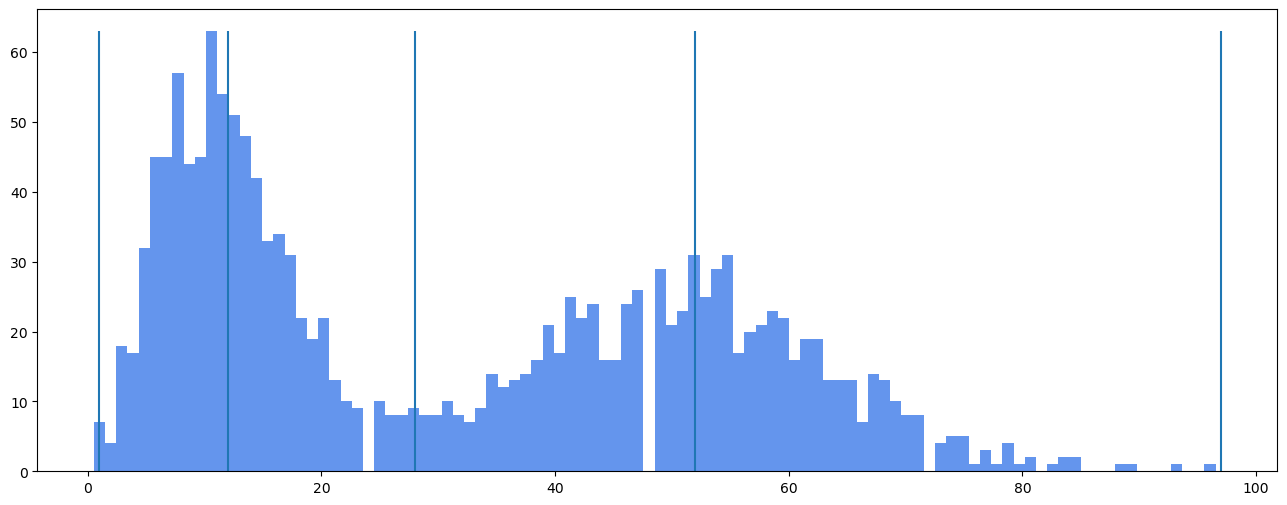

In [31]:
plt.figure(figsize = (16,6))
hist = plt.hist(rfm['Frequency'], bins=100,align='left', color='cornflowerblue')
for q in f_quarters:
    plt.vlines(q, ymin=0, ymax = max(hist[0]))

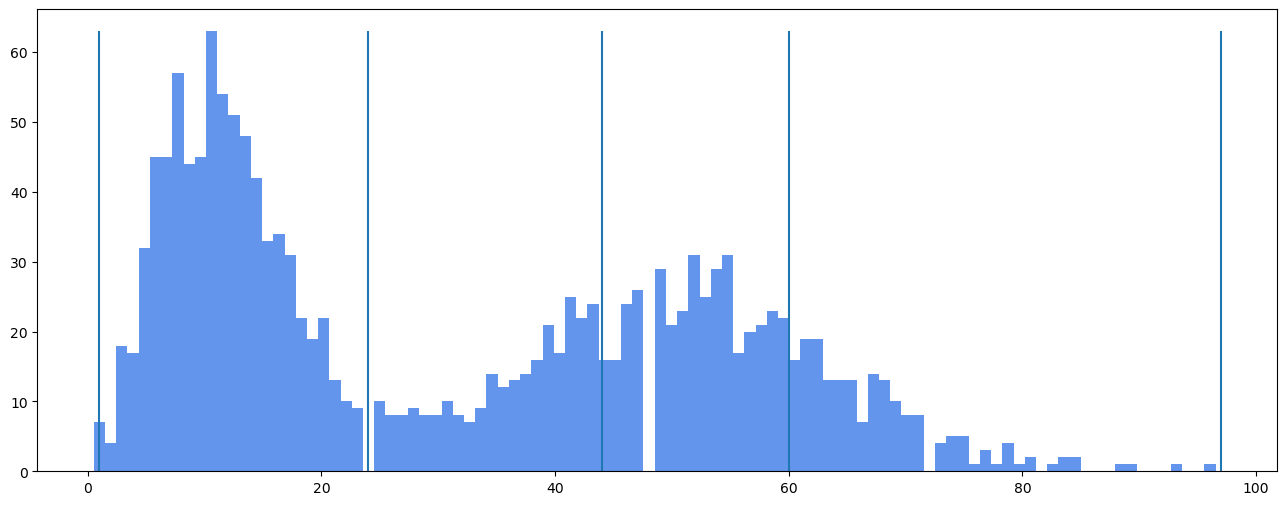

In [32]:
plt.figure(figsize = (16,6))
hist = plt.hist(rfm['Frequency'], bins=100,align='left', color='cornflowerblue')
for b in f_breaks:
    plt.vlines(b, ymin=0, ymax = max(hist[0]))

In [37]:
# Crediting camdenl with this function
# https://stats.stackexchange.com/users/27263/camdenl?tab=profile

def goodness_of_variance_fit(array, classes):
    # get the break points
    classes = jenkspy.jenks_breaks(array, n_classes=classes)

    # do the actual classification
    classified = np.array([classify(i, classes) for i in array])

    # max value of zones
    maxz = max(classified)

    # nested list of zone indices
    zone_indices = [[idx for idx, val in enumerate(classified) if zone + 1 == val] for zone in range(maxz)]

    # sum of squared deviations from array mean
    sdam = np.sum((array - array.mean()) ** 2)

    # sorted polygon stats
    array_sort = [np.array([array[index] for index in zone]) for zone in zone_indices]

    # sum of squared deviations of class means
    sdcm = sum([np.sum((classified - classified.mean()) ** 2) for classified in array_sort])

    # goodness of variance fit
    gvf = (sdam - sdcm) / sdam

    return gvf

def classify(value, breaks):
    for i in range(1, len(breaks)):
        if value < breaks[i]:
            return i
    return len(breaks) - 1

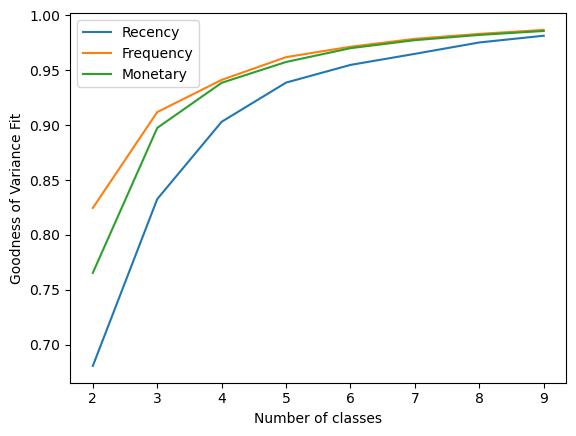

In [38]:
my_dict = {}
for col in rfm.columns[:3]:
    results = []
    for i in range(2, 10):
        results.append(goodness_of_variance_fit(rfm[col], i))
    my_dict[col] = results  
plt.plot(range(2, 10), my_dict['Recency'], label='Recency')
plt.plot(range(2, 10), my_dict['Frequency'], label='Frequency')
plt.plot(range(2, 10), my_dict['Monetary'], label='Monetary')
plt.xlabel('Number of classes')
plt.ylabel('Goodness of Variance Fit')
plt.legend(loc='best')
plt.show()

In [40]:
breaks_list = [r_breaks, f_breaks, m_breaks]

rfm['r_j_score'] = pd.cut(rfm['Recency'], bins=r_breaks, labels=[1, 2, 3, 4], include_lowest=True)
rfm['f_j_score'] = pd.cut(rfm['Frequency'], bins=f_breaks, labels=[4, 3, 2, 1], include_lowest=True)
rfm['m_j_score'] = pd.cut(rfm['Monetary'], bins=m_breaks, labels=[4, 3, 2, 1], include_lowest=True)

rfm.drop(['r_percentile', 'f_percentile', 'm_percentile'], axis=1, inplace=True)
rfm.head(5)

,Recency,Frequency,Monetary,r_score,f_score,m_score,rfm_score,r_j_score,f_j_score,m_j_score
Customer ID,,,,,,,,,,
AA-10315,9,42,15578.04,1,2,1,121,1,3,2
AA-10375,7,42,7272.89,1,2,3,123,1,3,3
AA-10480,118,38,18467.63,4,2,1,421,2,3,2
AA-10645,27,73,16691.92,2,1,1,211,1,1,2
AA-315,3,8,2499.63,1,4,3,143,1,4,4


In [41]:
rfm['rfm_j_score'] = rfm['r_j_score'].astype(str) + rfm['f_j_score'].astype(str) + rfm['m_j_score'].astype(str)

In [42]:
rfm.head(5)

,Recency,Frequency,Monetary,r_score,f_score,m_score,rfm_score,r_j_score,f_j_score,m_j_score,rfm_j_score
Customer ID,,,,,,,,,,,
AA-10315,9,42,15578.04,1,2,1,121,1,3,2,132
AA-10375,7,42,7272.89,1,2,3,123,1,3,3,133
AA-10480,118,38,18467.63,4,2,1,421,2,3,2,232
AA-10645,27,73,16691.92,2,1,1,211,1,1,2,112
AA-315,3,8,2499.63,1,4,3,143,1,4,4,144


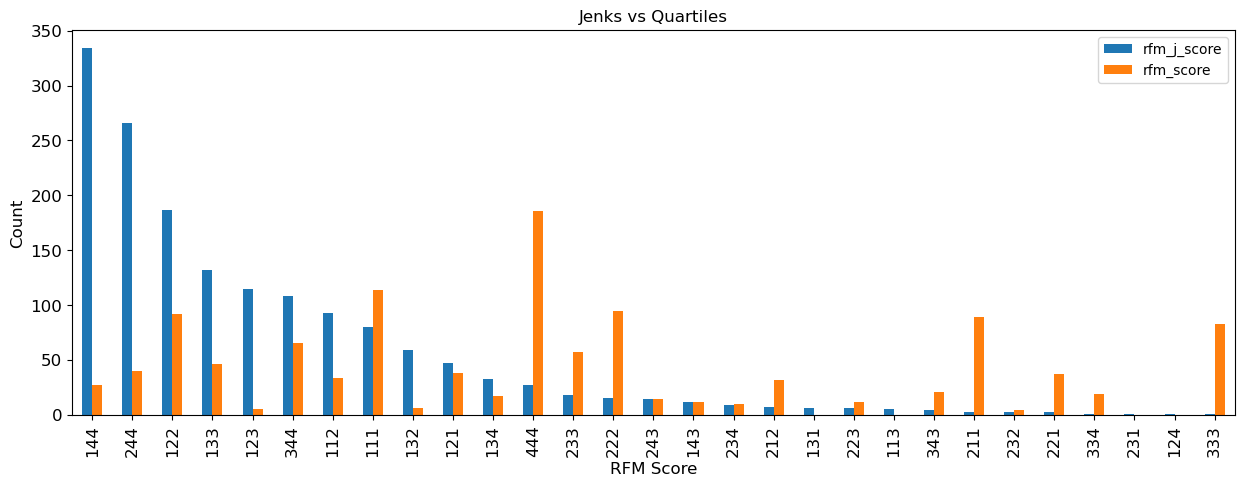

In [43]:
df = rfm['rfm_j_score'].value_counts().to_frame().join(rfm['rfm_score'].value_counts())
ax = df.plot(kind='bar', title ="Jenks vs Quartiles", figsize=(15, 5), legend=True, fontsize=12)
ax.set_xlabel("RFM Score", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

In [45]:
import hdbscan

In [46]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=30,min_samples=12, metric='euclidean')

In [47]:
clusterer.fit(rfm[['Recency', 'Frequency', 'Monetary']])

HDBSCAN(min_cluster_size=30, min_samples=12)

In [48]:
rfm['Cluster'] = pd.Series(clusterer.labels_, index=rfm.index)

In [49]:
rfm.head(5)

,Recency,Frequency,Monetary,r_score,f_score,m_score,rfm_score,r_j_score,f_j_score,m_j_score,rfm_j_score,Cluster
Customer ID,,,,,,,,,,,,
AA-10315,9,42,15578.04,1,2,1,121,1,3,2,132,1
AA-10375,7,42,7272.89,1,2,3,123,1,3,3,133,1
AA-10480,118,38,18467.63,4,2,1,421,2,3,2,232,1
AA-10645,27,73,16691.92,2,1,1,211,1,1,2,112,1
AA-315,3,8,2499.63,1,4,3,143,1,4,4,144,3


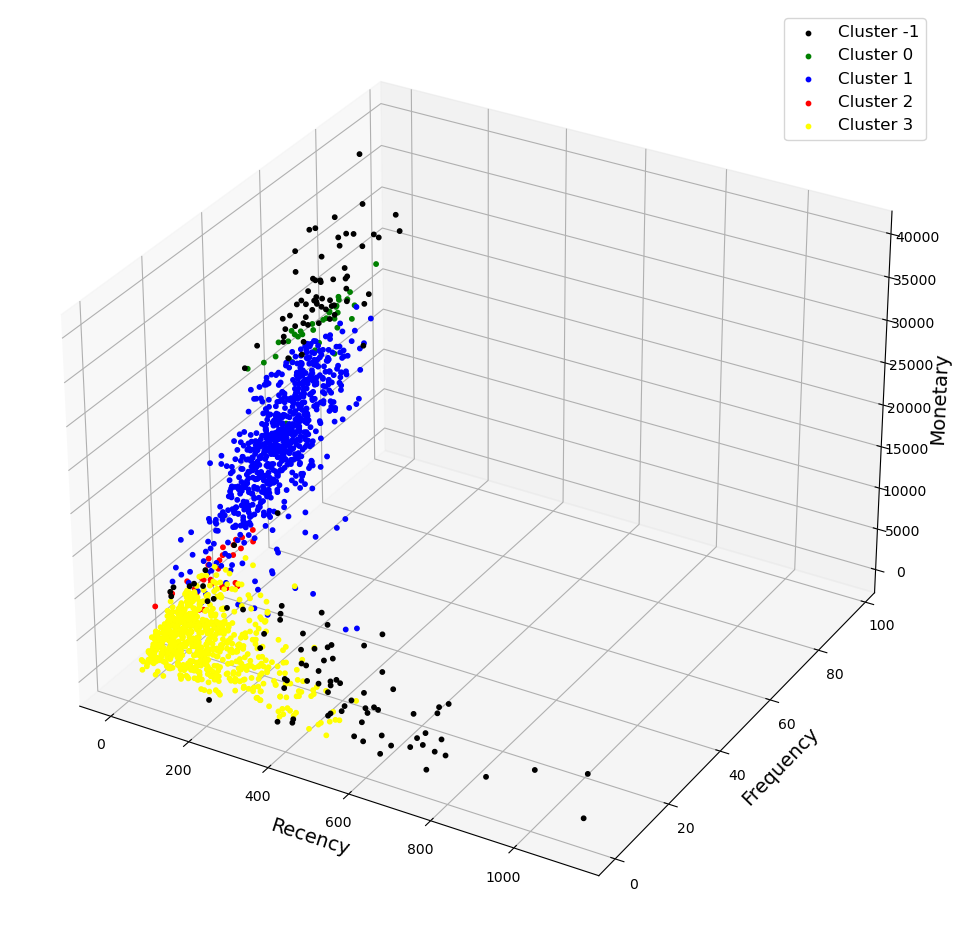

In [51]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors

fig = plt.figure(figsize=(18,12))
dx = fig.add_subplot(111, projection='3d')
colors = ['green', 'blue', 'red', 'yellow', 'black']
#colors = [k for k in mclolors.CSS4_COLORS ]

for i in range(-1,len(rfm['Cluster'].unique())-1):
    dx.scatter(rfm[rfm.Cluster == i].Recency,
              rfm[rfm.Cluster == i].Frequency,
               rfm[rfm.Cluster ==i].Monetary,
               c = colors[i],
               label = 'Cluster ' + str(i),
               s=10, alpha=1.0)
dx.set_xlabel('Recency', fontsize=14)
dx.set_ylabel('Frequency', fontsize=14)
dx.set_zlabel('Monetary', fontsize=14)
dx.legend(fontsize=12)

In [53]:
pd.Series(clusterer.labels_).value_counts()

 1    715
 3    667
-1    142
 0     34
 2     32
dtype: int64

In [54]:
myDict = {}
for i in range(0, len(rfm['Cluster'].unique())-1):
    clust = rfm[rfm['Cluster'] == i]
    myDict['Cluster ' + str(i)] = [int(round(clust['Recency'].mean(),0)),
                            int(round(clust['Frequency'].mean(),0)),
                            int(round(clust['Monetary'].mean(),0)),
                            int(round(clust['Recency'].median(),0)),
                            int(round(clust['Frequency'].median(),0)),
                            int(round(clust['Monetary'].median(),0))]
    
df = pd.DataFrame.from_dict(myDict, orient='index',
                            columns=['mean_Recency','mean_Frequency', 'mean_Monetary',
                                    'median_Recency','median_Frequency', 'median_Monetary'])
df

,mean_Recency,mean_Frequency,mean_Monetary,median_Recency,median_Frequency,median_Monetary
Cluster 0,35,63,24590,24,62,24639
Cluster 1,38,49,14642,24,50,14614
Cluster 2,40,25,5808,35,23,5807
Cluster 3,111,12,2079,86,12,1889


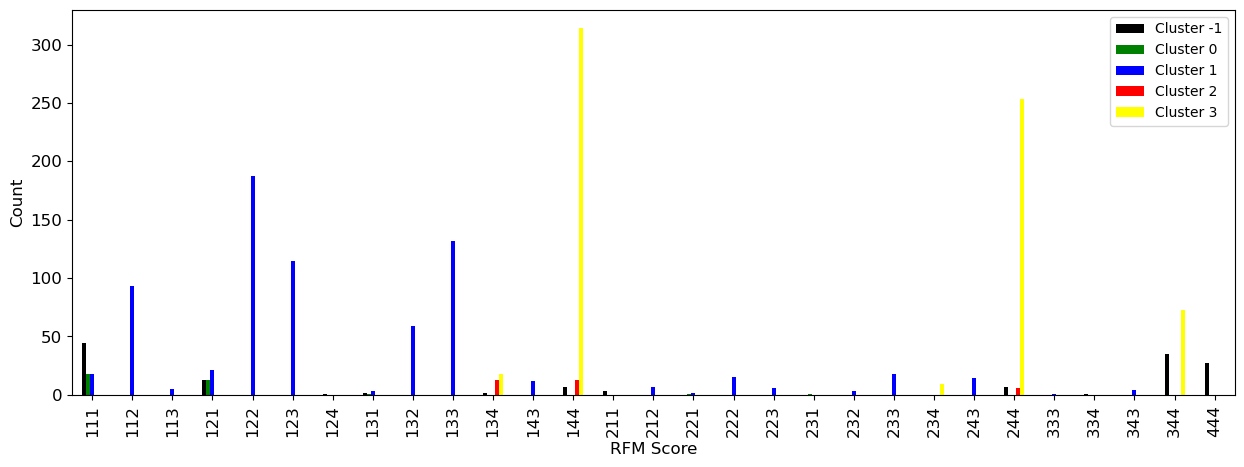

In [55]:
myDict = {}
for i in range(-1, len(rfm['Cluster'].unique())-1):
    clust = rfm[rfm['Cluster'] == i]
    myDict["Cluster " + str(i)] = clust['rfm_j_score'].value_counts()
df = pd.DataFrame.from_dict(myDict)

colors = ['black', 'green', 'blue', 'red', 'yellow']
ax = df.plot(kind='bar', figsize=(15, 5), legend=True, fontsize=12, color=colors)
ax.set_xlabel("RFM Score", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()